In [1]:
import numpy as np
import matplotlib.pyplot as plt

Text(0, 0.5, 'pz (keV/c)')

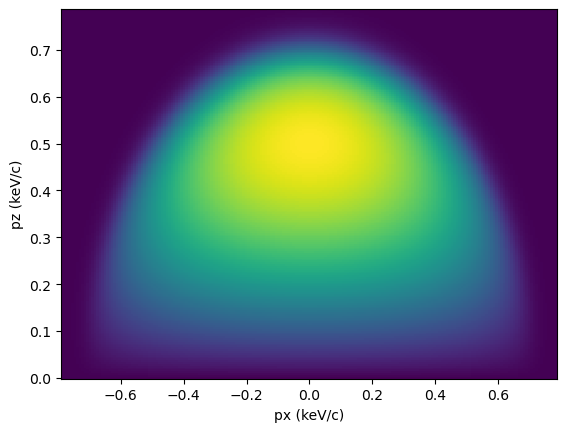

In [2]:
kb = 8.617333262e-5  # eV/K from CODATA recommendation
mc2 = 510.998950e3

def fermi_dirac(e, mu, t, t_cutoff=1e-3):
    """
    Fermi-Dirac distribution
    :param e: energy to evaluate at
    :param mu: Fermi energy
    :param t: Temperature
    :param t_cutoff: Clip the temperature at this value to avoid divide by zero
    :return: value of the Fermi-Dirac distribution
    """
    return 1/(1 + np.exp(np.clip((e - mu)/(kb*np.clip(t, t_cutoff, None)), -256, 256)))


def dowell_schmerge_pdf_int(px, py, pz, fermi_energy, temp, photon_energy, workfun):
    e = (px**2 + py**2 + pz**2)/2/mc2
    p_excite = (1 - fermi_dirac(e + photon_energy, fermi_energy, temp))*fermi_dirac(e, fermi_energy, temp)
    p_transport = pz > 0
    p_escape = pz**2/2/mc2 + photon_energy >= fermi_energy + workfun
    return p_excite*p_transport*p_escape


def ds_transform(px, py, pz, fermi_energy, photon_energy, workfun):
    a = np.sqrt(1 - photon_energy/((px**2 + py**2 + pz**2)/2/mc2 + fermi_energy + workfun))
    return px*a, py*a, np.sqrt(pz**2 + 2*mc2*(fermi_energy + workfun))*a


def ds_jacobian_factor(px, py, pz, fermi_energy, photon_energy, workfun):
    num = pz*np.sqrt(px**2 + py**2 + pz**2 + 2*mc2*(fermi_energy + workfun - photon_energy))
    den = np.sqrt((pz**2 + 2*mc2*(fermi_energy + workfun))*(px**2 + py**2 + pz**2 + 2*mc2*(fermi_energy + workfun)))
    return num/den


def dowell_schmerge_pdf(px, py, pz, photon_energy, workfun, temp, fermi_energy):
    """
    Calculates the (unnormalized) PDF for electrons emitted from a photocathode following the
    model described in [1]. Shortly, electrons are initially populated in momentum space as 
    in the Sommerfeld model. They escape over the work function barrier when their 
    longitudinal energy is high enough and lose momentum along the direction of the surface 
    normal to satisfy energy conservation. For the purposes of referencing in published 
    research, this sampling concept is the same described in [2].

    [1] Dowell, D. H., & Schmerge, J. F. (2009). Quantum efficiency and thermal emittance of 
        metal photocathodes. Physical Review Special Topics - Accelerators and Beams, 12(7). 
        https://doi.org/10.1103/PhysRevSTAB.12.074201

    [2] Pierce, C. M., Durham, D. B., Riminucci, F., Dhuey, S., Bazarov, I., Maxson, J.,
        Minor, A. M., & Filippetto, D. (2023). Experimental Characterization of Photoemission
        from Plasmonic Nanogroove Arrays. Physical Review Applied, 19(3), 034034.
        https://doi.org/10.1103/PhysRevApplied.19.034034

    :params px: x component of momentum (in eV/c)
    :params py: y component of momentum (in eV/c)
    :params pz: z component of momentum (in eV/c)
    :params photon_energy: photon energy of driving laser (in eV)
    :params workfun: photocathode work function (in eV)
    :params temp: photocathode temperature (in K)
    :params fermi_energy: photocathode Fermi energy (in eV; note, PDF should be insensitive to this value)
    :return: unnormalized density of the emitted electrons at this momentum
    """
    a = ds_jacobian_factor(px, py, pz, fermi_energy, photon_energy, workfun)
    return a*dowell_schmerge_pdf_int(*ds_transform(px, py, pz, fermi_energy, photon_energy, workfun), fermi_energy, temp, photon_energy, workfun)


def dowell_schmerge_pdf_bounds(photon_energy, workfun, temp, fermi_energy, n_tails=4):
    """
    Calculates bounding box of the non-zero part of the PDF
    :param temp: photocathode emperature (in K)
    :param photon_energy: photon energy of the driving laser (in eV)
    :param workfun: photocathode work function (in eV)
    :param n_tails: amount of Fermi tail to include (in units of kB*T)
    :return: (xl, xu), (yl, yu), (zl, zu), the lower (l) and upper (u) bounds along each axis (x, y, z)
    """
    a = np.sqrt(2*mc2*(photon_energy - workfun + kb*temp*n_tails))
    return [(-a, a), (-a, a), (0., a)]


fermi_energy = 6
t = 300
photon_energy = 2.5
workfun = 2

n_points = 200
(bxm, bxp), (bym, byp), (bzm, bzp) = dowell_schmerge_pdf_bounds(photon_energy, workfun, t, fermi_energy)
px, py, pz = np.mgrid[bxm:bxp:1j*n_points, bym:byp:1j*n_points, bzm:bzp:1j*n_points]

rho = np.sum(dowell_schmerge_pdf(px, py, pz, photon_energy, workfun, t, fermi_energy), axis=1)
plt.pcolormesh(1e-3*px[:, 0, :], 1e-3*pz[:, 0, :], rho)
plt.xlabel("px (keV/c)")
plt.ylabel('pz (keV/c)')

Text(0, 0.5, 'MTE (meV)')

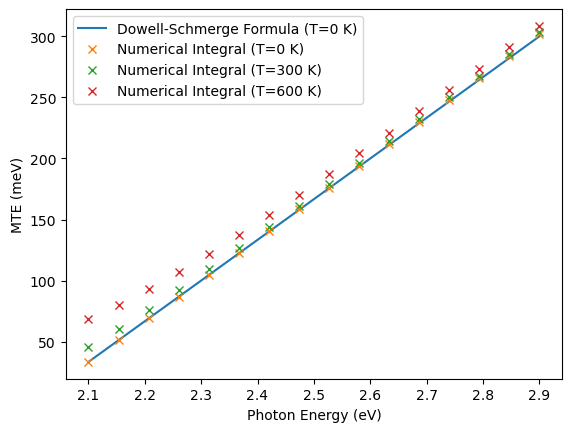

In [3]:
def get_mte(fermi_energy, t, photon_energy, workfun, n_points=128):
    (bxm, bxp), (bym, byp), (bzm, bzp) = dowell_schmerge_pdf_bounds(photon_energy, workfun, t, fermi_energy)
    px, py, pz = np.mgrid[bxm:bxp:1j*n_points, bym:byp:1j*n_points, bzm:bzp:1j*n_points]
    rho = dowell_schmerge_pdf(px, py, pz, photon_energy, workfun, t, fermi_energy)
    norm = np.trapz(np.trapz(np.trapz(rho, dx=px[1, 0, 0] - px[0, 0, 0], axis=0), dx=py[0, 1, 0] - py[0, 0, 0], axis=0), dx=pz[0, 0, 1] - pz[0, 0, 0])
    px_sec_moment = np.trapz(np.trapz(np.trapz(px**2*rho, dx=px[1, 0, 0] - px[0, 0, 0], axis=0), dx=py[0, 1, 0] - py[0, 0, 0], axis=0), dx=pz[0, 0, 1] - pz[0, 0, 0])
    return (px_sec_moment/norm)/mc2*1e3

ephoton = np.linspace(2.1, 2.9, 16)
plt.plot(ephoton, (ephoton-2)/3*1e3, label='Dowell-Schmerge Formula (T=0 K)')

for temp in [0, 300, 600]:
    mte = np.array([get_mte(6., temp, ep, 2.) for ep in ephoton])
    plt.plot(ephoton, mte, marker='x', ls='none', label='Numerical Integral (T=%.0f K)' % temp)
plt.legend()
plt.xlabel('Photon Energy (eV)')
plt.ylabel('MTE (meV)')